In [1]:
%reset -f

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import os
import matplotlib.pyplot as plt
import time


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

os.getcwd()

data_dir = os.getcwd()

print("Cell evaluated")

Instructions for updating:
non-resource variables are not supported in the long term
Cell evaluated


# Importing the data

In [2]:
def get_food_dat(filename):
    
    food_dict = {}
    
    food_df = pd.read_csv(os.path.join(data_dir,filename))
    foodname = food_df.iloc[:,0].str.upper().to_numpy()
    foodcal = food_df.iloc[:,1].to_numpy()
    foodcost = food_df.iloc[:,2].to_numpy()
    
    for name,calories,val in zip(foodname, foodcal,foodcost):
        food_dict[name] = [calories,val]
    return food_dict

food_dat = get_food_dat('FoodData.csv')

# First element in array is calories (per week). Second element of array is cost of basket (per week)

# dictionary structure: 
# {basket 1: [cal, cost, items], basket 2: [cal, cost, items], basket 3: [cal, cost, items], etc}

print("Cell evaluated")

Cell evaluated


# Visualizing the data

# Sorting the Baskets

Text(0.5, 0, 'Calories in basket')

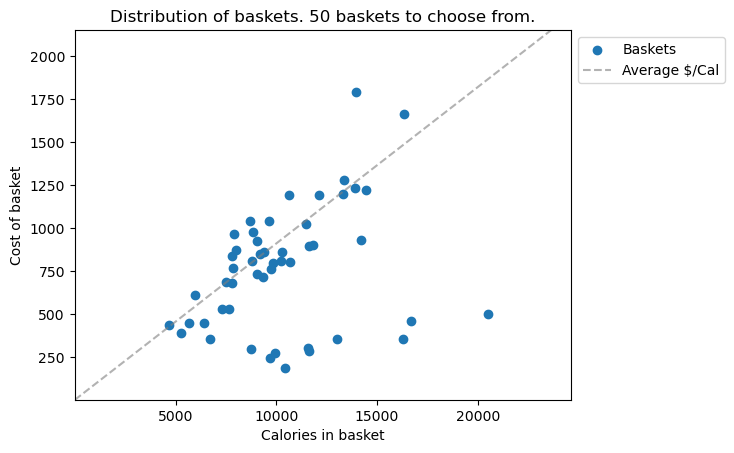

In [3]:

nbaskets = 50                              # number of pre-made food baskets
bdict = dict({})
rk2 = np.random.RandomState(12)            # Seed for the local RNG when randomly creating baskets of food

for nb in range(nbaskets):
    
    rchoice = rk2.randint(20,80)
    zk1 = rk2.choice(len(food_dat), rchoice, replace=True)
    
    cal_list = [list(food_dat.values())[i][0] for i in zk1]
    cost_list = [list(food_dat.values())[i][1] for i in zk1]
    
    bdict["Basket "+str(nb)] = [np.sum(cal_list),np.sum(cost_list),np.array(sorted(list(food_dat.keys())))[zk1]]
    
calslist_costlist = np.array(list(food_dat.values())).T
cost_per_cals = np.sum(calslist_costlist[1])/np.sum(calslist_costlist[0])   # Average cost per calories for food

####################################################################
# Adds some baskets containing high_calories-low_cost food
calpd = dict({})
food_list = list(food_dat.keys())

for food,data in food_dat.items():
    calpd[food] = data[0]/data[1]
    
food_list = [x for _, x in sorted(zip(list(calpd.values()), food_list))]
highcal_lowcost_food =  {food_list[int(len(food_list)*2/3) + i]:food_dat[food_list[int(len(food_list)*2/3) + i]] for i in range(int(len(food_list)*1/3))}


bdict = dict({})
n_premade = 10 # number of baskets to sort using this method
for nb in range(nbaskets-n_premade):
    rchoice = rk2.randint(20,60)
    zk1 = rk2.choice(len(food_dat), rchoice, replace=True)
    
    cal_list = [list(food_dat.values())[i][0] for i in zk1]
    cost_list = [list(food_dat.values())[i][1] for i in zk1]
    
    bdict["Basket "+str(nb)] = [np.sum(cal_list),np.sum(cost_list),sorted(np.array(list(food_dat.keys()))[zk1])]
    
for nb in range(nbaskets-n_premade, nbaskets):
    rchoice = rk2.randint(20,50)
    zk1 = rk2.choice(len(highcal_lowcost_food), rchoice, replace=True)
    
    cal_list = [list(highcal_lowcost_food.values())[i][0] for i in zk1]
    cost_list = [list(highcal_lowcost_food.values())[i][1] for i in zk1]
    bdict["Basket "+str(nb)] = [np.sum(cal_list),np.sum(cost_list),sorted(np.array(list(highcal_lowcost_food.keys()))[zk1])]
    
####################################################################

bcost = list([])
bcals = list([])
for bb in bdict:
#     print("Cals:", bdict[bb][0], ", Cost: %.3f" %bdict[bb][1],", items:", len(bdict[bb][2]), ", Uniques:", len(set(bdict[bb][2])))
    bcost.append(bdict[bb][1])
    bcals.append(bdict[bb][0])
    
plt.title("Distribution of baskets. 50 baskets to choose from.")
plt.scatter(bcals,bcost,label="Baskets")
plt.plot(cost_per_cals * np.arange(1.2*np.max(bcals)),linestyle='dashed', color='gray',alpha=0.6, label="Average $/Cal")
plt.ylim(1,1.2*np.max(bcost))
plt.xlim(1,1.2*np.max(bcals))
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')
plt.ylabel("Cost of basket")
plt.xlabel("Calories in basket")
    
  

### Environment for recommender system

In [4]:
class fenv3:  
    
    def __init__(self, calorie_intake, budget_provided, variety_importance, calories_importance, nweeks, food_data, cal_window = [0.2, 0.15, 0.1, 0.05]):  
        self.nweeks = nweeks
        self.variety_importance = variety_importance
        self.calories_importance = calories_importance
        

        self.window1, self.window2, self.window3, self.window4 = sorted(cal_window,reverse=True)

        
        if isinstance(calorie_intake, (list, np.ndarray)):
            if len(calorie_intake) != self.nweeks:
                print("!!! Calories intake provided does not match duration of programme !!!")
            self.cal_target_list = np.array(calorie_intake)
        else:
            print("Calories input: Daily")
            self.cal_target_list = np.array([calorie_intake*7 for _ in range(self.nweeks)])
        
        if isinstance(budget_provided, (list, tuple, np.ndarray)):
            if len(budget_provided) != self.nweeks:
                print("!!! Budget provided provided does not match duration of programme !!!")
            self.budget_list = np.array(budget_provided)
            self.budget_total = np.sum(self.budget_list)      # Total budget of programme
        else:
            print("Budget input: Monthly")
            self.budget_list = np.array([(budget_provided/30)*7 for _ in range(self.nweeks)])
            self.budget_total = np.sum(self.budget_list)      # Total budget of programme
            
        self.budget_remaining = self.budget_total
        
        # Sorting the data
        self.food_data = food_data
        self.food_cal = np.array([x[0] for x in list(self.food_data.values())])
        self.food_cost = np.array([x[1] for x in list(self.food_data.values())])
        self.number_of_food = len(self.food_cal)
        
        self.n_actions = len(food_data)                      # Number of actions
        self.n_observations = 6                              # Number of observations from a state (n_features)
        
        
        # For saving data:
        self.history = np.array([])                          # History of recommendations
        self.cal_history = list([])                          # Saves whether weight lost or gained
        self.budget_history = list([])                       # Check how many times we went overbudget
        self.total_spent = 0                                 # Checks the total cost of all our items
        
    def reset(self):                                         # Resets the state of the environment
        # Reset budget and history
        self.budget_remaining = self.budget_total
        self.history = np.array([])
        self.cal_history = list([])
        self.budget_history = list([])
        self.current_week = 0
        self.total_spent = 0   

        self.monthly_budget = np.sum(self.budget_list[:4])
        self.monthly_budget_remaining = self.monthly_budget
        
        self.monthly_cals_target = np.sum(self.cal_target_list[:4])
        self.monthly_cals_consumed = 0
        
                                         
        # normalize data
        observation = np.array([0,                           # Ratio of rec cost to weekly budget
                                1,                           # Budget remaining for the programme
                                0,                           # Deviation of calories for entire programme
                                1,                           # Long term history
                                0,                           # Short term history
                                0,                           # Number of weeks overbudget
                                ])
        
        return observation
    
    def step(self, actions): # Takes in an action, changes the state accordingly and calculates the reward

        if self.current_week == 0:
            self.history =  np.array([actions])
        else:
            self.history =  np.append(self.history, actions)

        total_calories_of_action = self.food_cal[actions]
        total_cost_of_action = self.food_cost[actions]
        
        budget_curr_week = self.budget_list[self.current_week]            # Budget for this timestep
        caltarget_curr_week = self.cal_target_list[self.current_week]     # 
        self.total_spent += total_cost_of_action
        
        self.monthly_budget_remaining -= total_cost_of_action 
        self.monthly_cals_consumed += total_calories_of_action
        
        self.cal_history.append(total_calories_of_action)

        #++++++++++++++ Section to calculate reward based on calorie intake ++++++++++++++
        # Cumulative reward given based on how close you are to target
        # Essentially a "fitting" problem, and "closeness" is determined by least squares value
        cal_reward = 0
        off_cal = ((total_calories_of_action - caltarget_curr_week)**2)/(caltarget_curr_week**2)
        if off_cal <= self.window1:                          
            cal_reward += 3                     
        if off_cal <= self.window2:
            cal_reward += 7
        if off_cal <= self.window3:
            cal_reward += 5
        if off_cal <= self.window4:
            cal_reward += 3
        
        #++++++++++++++ Section to calculate reward based on variety ++++++++++++++
        # Cumulative reward given based on variety of week-to-week recommendation
        variety_reward = 0                              
        if len(set(self.history[-2:])) >= 2:
            variety_reward += 3
        if len(set(self.history[-5:])) >= 3:
            variety_reward += 7
        if len(set(self.history[-8:])) >= 5:
            variety_reward += 5
        if len(set(self.history)) >= 9:
            variety_reward += 3


        #++++++++++++++ Total reward based on calories, variety, and budget ++++++++++++++
        reward = (self.variety_importance*variety_reward + self.calories_importance*cal_reward)
        reward = reward/(self.variety_importance + self.calories_importance)
        if total_cost_of_action > budget_curr_week:                                 
            reward = 0.6*reward                                 # Overbudget for the week
            self.budget_history.append(1)       
        if self.monthly_budget_remaining < 0:
            reward = 0.3*reward                                 # Overbudget for the month
        if self.total_spent > self.budget_total: 
            reward = 0                                          # Overbudget for the programme
        if self.current_week >= 17 and len(set(self.history)) <= 2*self.variety_importance:
            reward = 0                                          # Low overall variety
            
    
        #++++++++++++++ At the end of every month..... ++++++++++++++
        if self.current_week%4 == 0:
            # Fancy way of obtaining the budget for the month given the week that we're in
            self.monthly_budget = np.sum(self.budget_list[(self.current_week//4)*4:((self.current_week//4)*4)+4])
            self.monthly_budget_remaining = self.monthly_budget
            
            self.monthly_cals_target = np.sum(self.cal_target_list[(self.current_week//4)*4:((self.current_week//4)*4)+4])
            self.monthly_cals_consumed = 0
                
        #++++++++++++++ Normalize observations for the purposes of NN:
        budget_remaining = self.monthly_budget_remaining/self.monthly_budget
        calories_rec = total_calories_of_action/caltarget_curr_week
        
        cals_deviation = np.abs(np.array(self.cal_history)-self.cal_target_list[:self.current_week+1])**2
        cals_deviation = np.sum(cals_deviation/(self.cal_target_list[:self.current_week+1]**2))
        self.current_week += 1
        
        # What the agent observes from the state. (Normalized for purposes of Neural Network)
        observation = np.array([total_cost_of_action/budget_curr_week,                 # Ratio of rec cost to weekly budget                                    
                                budget_remaining,                                      # Budget remaining for the programme
                                calories_rec,                                          # Calories recommended for that week
                                cals_deviation,                                        # Deviation of calories for entire programme
                                len(set(self.history[-10:]))/len(self.history[-10:]),  # Long term history
                                len(set(self.history[-3:]))/3,                         # Short term history
                                ])

        
        return observation, max([0,np.ceil(reward)]) # return observation and reward
              


print("Cell evaluated")

Cell evaluated


### Agent

In [5]:
class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001, seed=None):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "act")
        self.td_error = tf.placeholder(tf.float32, None, "td_error")            # TD_err
        self.rs1 = np.random.RandomState(seed)
        

        with tf.variable_scope('Actor', reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=n_features,                                               # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1, seed),  # weights
                bias_initializer=tf.constant_initializer(0.1),                  # biases
                name='l1'
            )
            self.acts_prob = tf.layers.dense(
                inputs=l1,
                units=n_actions,                                                # output units
                activation=tf.nn.softmax,                                       
                kernel_initializer=tf.random_normal_initializer(0., .1, seed),  # weights
                bias_initializer=tf.constant_initializer(0.1),                  # biases
                name='acts_prob'
            )


        with tf.variable_scope('exp_v', reuse=tf.AUTO_REUSE):
            log_prob = tf.log(self.acts_prob[0, self.a])
            self.exp_v = tf.reduce_mean(log_prob * self.td_error)               # advantage (TD_error) guided loss

        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)    # maximizing(-expv) = minimizing(expv)

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.acts_prob, {self.s: s})                      # get probabilities for all actions
        pick_action =  self.rs1.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int
        return pick_action


class Critic(object):
    def __init__(self, sess, n_features, lr=0.01, seed=None):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.v_ = tf.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.placeholder(tf.float32, None, 'r')

        with tf.variable_scope('Critic', reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=n_features,                                               # number of hidden units
                activation= tf.nn.relu, # None
                kernel_initializer=tf.random_normal_initializer(0., .1, seed),  # weights
                bias_initializer=tf.constant_initializer(0.1),                  # biases
                name='l1'
            )
            self.v = tf.layers.dense(
                inputs=l1,
                units=1,                                                        # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1, seed),  # weights
                bias_initializer=tf.constant_initializer(0.1),                  # biases
                name='V'
            )
        with tf.variable_scope('squared_TD_error', reuse=tf.AUTO_REUSE):
            self.td_error = self.r + GAMMA * self.v_ - self.v
            self.loss = tf.square(self.td_error)                                # TD_err = (r + gamma*V_{t+1}) - V_t
        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error
    
print("Cell evaluated")
    

Cell evaluated


# Creating a calories/budget target

In [6]:
# Profile parameters
plan_duration = 52                           # number of weeks to run for

weekly_target = 2000                         # calories per day
holiday_target = 2500                        # calories per day for holiday season

weekly_target = weekly_target * 7            # convert to weekly
holiday_target = holiday_target * 7          # convert to weekly

#++++++++++++++++++++   Short bit to create target calories list   +++++++++++++++++++++++
calories_target_list = [weekly_target for _ in range(plan_duration)]
for k in range(4): # Set holiday period at start/end of the programme
    calories_target_list[k] = holiday_target
    calories_target_list[-k] = holiday_target
for k in range(4): # Set holiday period at middle of the programme
    calories_target_list[plan_duration//2 + k] = holiday_target
    calories_target_list[plan_duration//2 - k] = holiday_target

#++++++++++++++++++++   Short bit to create budget list   +++++++++++++++++++++++
budget_target_list = np.full(plan_duration, 570)          # Approx $2500 per month
budget_target_list[[0,1,2,3,9,51,50,49,24,25,26,27,39]] = 700
budget_target_list[[8,10,11,12,13,35,36,37,38,40,41]] = 500
profile_budget = budget_target_list
# profile_budget = 2000#1700                              # per month

profile_calories = calories_target_list    
variety_preference, calories_preference = 3,3
print("Profile created")

Profile created


### Perform recommendation

In [ ]:

# Hyperparameters
MAX_EPISODE = 300     # Max number of training episodes
LR_A = 0.0003         # learning rate for actor
LR_C = 0.003          # learning rate for critic
GAMMA = 0.93          # Reward discount in TD error
rseed = None          # Seeds the RNG. Either "None" or an integer

profile1 = fenv3(profile_calories, profile_budget,variety_preference,variety_preference,plan_duration, bdict)
                
nfeat =  profile1.n_observations
nact = profile1.n_actions
best_reward = -1e9

sess = tf.Session()

actor = Actor(sess, n_features=nfeat, n_actions=nact, lr=LR_A,seed = rseed)
critic = Critic(sess, n_features=nfeat, lr=LR_C, seed = rseed)    
sess.run(tf.global_variables_initializer())

training_progress = list([])
historical_best = list([])

ttime1 = time.time()
print("Begin training....")

for i_episode in range(MAX_EPISODE):             
    
    s = profile1.reset()                         # Reset environment
    t = 0                                        # Reset timestep
    track_r = []                                 # Reset reward tracker
    
    while True:

        a = actor.choose_action(s)
        s_, r = profile1.step(a)                 # Obtains the new state and reward from environment

        track_r.append(r)

        td_error = critic.learn(s, r, s_)        # gradient = grad[r + gam * V(s_) - V(s)]
        actor.learn(s, a, td_error)              # actual_gradient = grad[log_Pi(s,a) * td_err]

        s = s_
        t += 1                                   
        
        
        if t >= plan_duration:
            running_reward = sum(track_r)        # Tracks the cumulative reward

            if running_reward > best_reward:     # Saves the best recommendations found throughout training process
                best_reward = running_reward
                best_rec = profile1.history
                overbudget_count = np.sum(profile1.budget_history)
                
            historical_best.append(best_reward)
            
            if i_episode%50 == 0:
                
                time_elapsed = time.time() - ttime1
                time_per_episode = time_elapsed/(i_episode+1)
                time_left = (MAX_EPISODE-i_episode)*time_per_episode
                
                print("episode:", i_episode, ", current training reward:", int(running_reward), ", best found:", historical_best[-1],
                     ", time taken:", np.round(time_elapsed, 1), ", time left:", np.round(time_left,1))
                
            break
    
    training_progress.append(running_reward)
    if i_episode > 100 and len(set(training_progress[-3:])) == 1:  # Early termination criteria if training converges
        break

print("Training complete! Time taken: %.3fs" %(time.time() - ttime1))

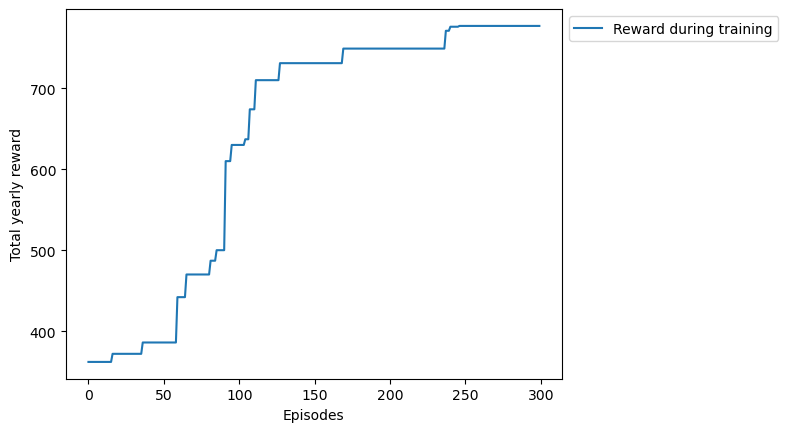

In [8]:
# plt.plot(training_progress, label="Reward during training")
plt.plot(historical_best, label="Reward during training")

plt.xlabel("Episodes")
plt.ylabel("Total yearly reward")
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')

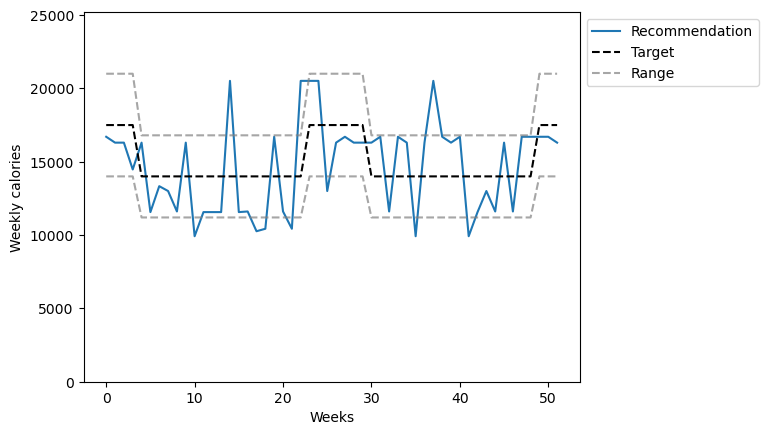

Number of weeks overbudget: 4
Total number of weeks for the programme: 52
Ideal basket to recommend each week:
[48 47 47 23 47 45  6 46 41 47 49 45 45 45 42 45 41 10 44 48 41 44 42 42
 42 46 47 48 47 47 47 48 41 48 47 49 47 42 48 47 48 49 45 46 41 47 41 48
 48 48 48 47]
Number of unique baskets: 11
Number of unique food items recommended: 57
Calories target (1yr): 777000 cals, Total calories consumed (1yr): 764917 cals
Total budget (1yr): $30560, Total cost (1yr): $21220


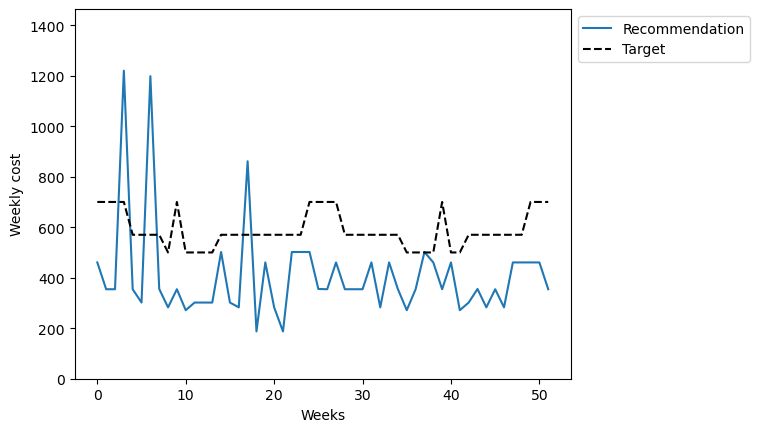

In [9]:
rec_cal_list = list([])
rec_cost_list = list([])
rec_food_list = list([])

for b_ in best_rec:
    rec_cal_list.append(bdict["Basket "+str(b_)][0])
    rec_cost_list.append(bdict["Basket "+str(b_)][1])
    for food in bdict["Basket "+str(b_)][2]:
        rec_food_list.append(food)

cal_range_upper = profile1.cal_target_list*(1+profile1.window1)      # Upper calories limit for plotting
cal_range_lower = profile1.cal_target_list*(1-profile1.window1)      # Lower calories limit for plotting
        
# Plots the calories target and recommendation
plt.plot(rec_cal_list, label="Recommendation")
plt.plot(profile1.cal_target_list, linestyle = "dashed", color='black',label="Target")
plt.plot(cal_range_upper, linestyle = "dashed", color='grey',label="Range",alpha=0.7)
plt.plot(cal_range_lower, linestyle = "dashed", color='grey',alpha=0.7)

# Settings for calories plot
plt.ylim(0, 1.2*np.max([np.max(cal_range_upper) , np.max(rec_cal_list)]) )
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')
plt.xlabel("Weeks")
plt.ylabel("Weekly calories")
plt.pause(0.01)

# Plots the budget and recommendation cost
plt.plot(rec_cost_list,label="Recommendation")
plt.plot(profile1.budget_list, linestyle = "dashed", color='black',label="Target")

# Settings for budget plot
plt.ylim(0,1.2*np.max([np.max(profile1.budget_list),np.max(rec_cost_list)]))
plt.legend(bbox_to_anchor=[1, 1], loc='upper left')
plt.xlabel("Weeks")
plt.ylabel("Weekly cost")

print("Number of weeks overbudget:", overbudget_count)
print("Total number of weeks for the programme:", plan_duration)

print("Ideal basket to recommend each week:")
print(best_rec)
print("Number of unique baskets:", len(set(best_rec)))
print("Number of unique food items recommended:", len(set(rec_food_list)))
print("Calories target (1yr): %.d cals, Total calories consumed (1yr): %.d cals" %(np.sum(profile1.cal_target_list), np.sum(rec_cal_list)))
print("Total budget (1yr): $%.d, Total cost (1yr): $%.d" %(np.sum(profile1.budget_list), np.sum(rec_cost_list)))



